In [1]:
#%% Import packages

import matplotlib.pyplot as plt
import copy
import pandas as pd
import numpy as np

from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.hazard import Hazard

import steps_functions as sfc

## Code structure

Based on unique CLIMADA objects (exposure, measure, … ) at
- Given years: defined objects by the user at given years
- Available years: derived unique objects
- Pathway years: the year we estimate the risk metric

### Inital parameters

In [2]:
START_YEAR = 2020
FUTURE_YEAR = 2070


## Step 1 - Organize the Exposure objects

### Create a exposure dictionary

In [3]:
# Parameters
# Input to function
year_0 = START_YEAR
year_1 = year_0+5
year_2 = year_1+5
year_3 = year_2 + 25



ent_USD = Entity.from_excel(ENT_DEMO_TODAY).exposures
ent_USD.gdf['value_unit'] = 'USD'
ent_PEOPLE = Entity.from_excel(ENT_DEMO_TODAY).exposures
ent_PEOPLE.gdf['value_unit'] = 'PEOPLE'

people_growth_rate = 0.01
usd_growth_rate = 0.02

# Build the exposure dictionary
exp_dict = {}
exp_dict[year_0] = [ent_USD, ent_PEOPLE]
# Give value_unit to the exposure 'USD'
exp_dict[year_1] = [copy.deepcopy(ent_USD), copy.deepcopy(ent_PEOPLE)]
exp_dict[year_1][0]
exp_dict[year_1][0].gdf.value *= (1+people_growth_rate)**(year_1-year_0)
exp_dict[year_1][1].gdf.value *= (1+usd_growth_rate)**(year_1-year_0)
# Give value_unit to the exposure 'USD'
exp_dict[year_2] = [copy.deepcopy(ent_USD), copy.deepcopy(ent_PEOPLE)]
exp_dict[year_2][0].gdf.value *= (1+people_growth_rate)**(year_2-year_0)
exp_dict[year_2][1].gdf.value *= (1+usd_growth_rate)**(year_2-year_0)
# Give value_unit to the exposure 'USD'
exp_dict[year_3] = [copy.deepcopy(ent_USD)]
exp_dict[year_3][0].gdf.value *= (1+usd_growth_rate)**(year_3-year_0)
# Add a new exposure point with slightly different location
exp_dict[year_3][0].gdf.iloc[-1, exp_dict[year_3][0].gdf.columns.get_loc('longitude')] = exp_dict[year_3][0].gdf.iloc[-1, exp_dict[year_3][0].gdf.columns.get_loc('longitude')] + 1.0


# Remove second item of the list in year_3
#exp_dict[year_0] = [exp_dict[year_0][0]]

### Generate expsoure function

For USD, the geo locations are different in the exposure sets
Total number of geo locations for USD is 51
Total number of geo locations for PEOPLE is 50
The number of exposure objects for USD is 4
The number of exposure objects for PEOPLE is 3


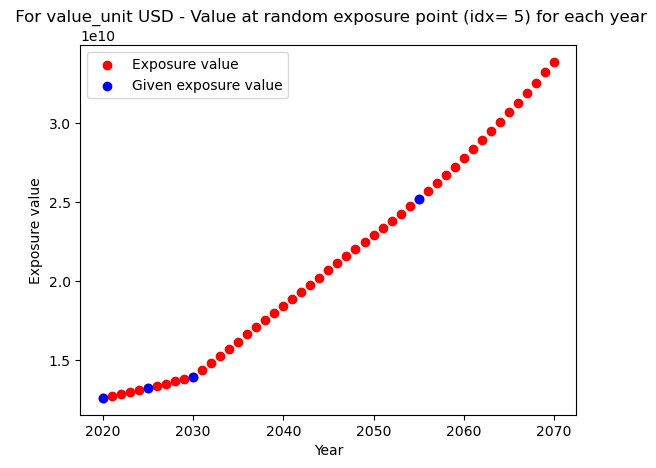

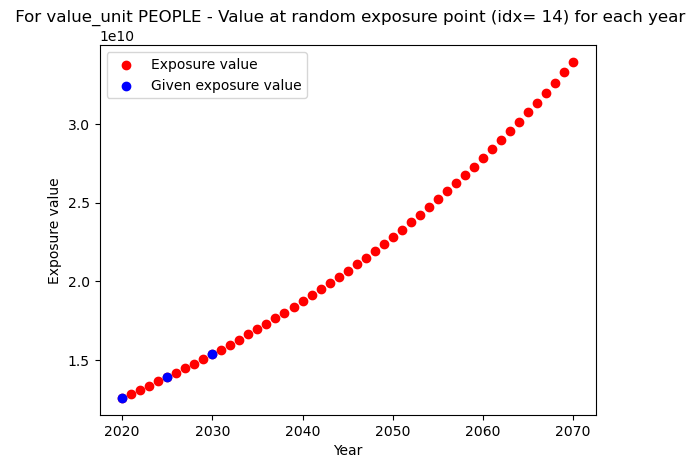

In [4]:

# Parameters
growth_rate = 0.08
year_future = FUTURE_YEAR
intr_param = 1

exp_avail_dict, exp_given_dict, exp_multipl_dict, exp_intrpl_dict = sfc.generate_exp_sets(exp_dict, intr_param,  future_year=year_future, growth_rate=0.02)

## Step 2 - Create the hazard container

In [5]:
# Parameters
# Input to function
year_0 = START_YEAR
year_1 = year_0+15
year_2 = year_1+5
year_3 = year_2 + 5

# Hazard set TC
haz_dict = {}
haz_dict[year_0] = Hazard.from_hdf5(HAZ_DEMO_H5)
haz_dict[year_1] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_1].intensity *= 1.5
haz_dict[year_2] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_2].intensity *= 2
haz_dict[year_3] = copy.deepcopy(haz_dict[year_0])
haz_dict[year_3].intensity *= 3

### Generate hazard attributes

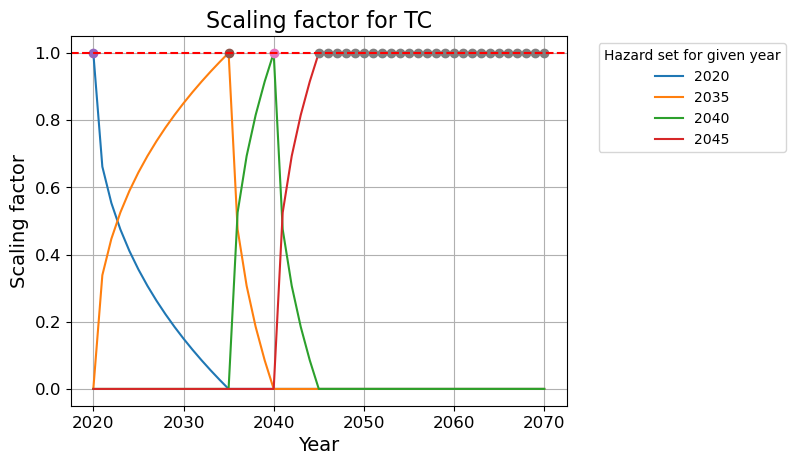

In [6]:
# Parameters
year_future = FUTURE_YEAR
intr_param = 0.4

haz_avail_dict, haz_given_dict, haz_param_dict = sfc.generate_haz_sets(haz_dict, intr_param, future_year=FUTURE_YEAR)

## Step 3 - Sample the event IDs

In [7]:
# Decide on sampling method
# Bayesian, or frequency based
sample_method = 'frequency' # 'bayesian' or 'frequency'

# Number of samples
n_samples = 100

sampled_eventIDs_dict, haz_Bayesian_select_dict = sfc.generate_sample_eventIDs(haz_avail_dict, haz_param_dict, future_year=FUTURE_YEAR, n_samples=n_samples, sample_method=sample_method)

## Step 4 - Create the impact fun sets active df

In [8]:
# Set the impact functions per year
imp_fun_set_dict = {} 
for year in [year_0, year_0+4, year_0+10]:
    imp_fun_set_dict[year] = Entity.from_excel(ENT_DEMO_TODAY).impact_funcs

impfs_avail_dict, impfs_given_dict, impfs_active_df = sfc.generate_impfs_active_df(imp_fun_set_dict, future_year=FUTURE_YEAR)

## Step 5 - Create the adapdation measures active df

In [9]:
# Define parameter adaptation measure dictionary
meas_dict = {}
for year in [year_0, year_0+3, year_0+12]:
    measure_set = Entity.from_excel(ENT_DEMO_TODAY).measures
    meas_dict[year] = copy.deepcopy(measure_set)
# Define parameter adaptation measure off
meas_inactive_years_dict = {'Seawall': [year_0+5, year_0+10], 'Building code': [year_0+1, year_0+12]}

# Generate the measure active dataframe
meas_avail_dict, meas_given_dict, meas_active_df = sfc.generate_meas_df(meas_dict, future_year= FUTURE_YEAR, meas_inactive_years_dict=meas_inactive_years_dict)

## Step 6 - Create the impact mapping opbjects

- Remember, for every given of an exposure, adaptation measure, impact_function_set and TC there is a unique impact object 
- Remember that if a measure is inactive it is the same as having no measure to sample from. 
    - For combinations of measure you then need to exclude sampling from that object.

In [10]:
imp_obj_map_df, imp_obj_unique_df = sfc.generate_imp_obj_df(exp_avail_dict, haz_avail_dict, impfs_active_df, exp_multipl_dict, haz_param_dict, meas_avail_dict, meas_active_df, incl_insurance = True)

## Step 7 - Create the unique impact objects

### Very important!!! If the measure involves changing the exposure points then the realtive impact matrix must be modified

In [11]:

imp_calc_params_kwargs = {'save_mat': True, 'assign_centroids': True, 'ignore_cover': False, 'ignore_deductible': False}

imp_abs_dict, imp_rel_dict = sfc.generate_imp_obj_dict(imp_obj_unique_df, exp_avail_dict, haz_avail_dict, impfs_avail_dict, meas_avail_dict, calc_rel_imp = True, imp_calc_params_kwargs= imp_calc_params_kwargs)

## Step 8 - Create the combined measures impact objects

- Make possible to calcualte the aboslute or relative impact marix based on either 
    - Capped sum of impacted
    - Convolution of impact measures 

## Step 9 - Calculate the simulated exposure values and impacts over time

1. sim_exp_cent_per_event_value_matrix and sim_exp_cent_per_event_impact_matrix
    - store in dictioany for each measure
    - rows are simualted trajectories and columns are path years and cells are a list with inner list being an event and an inner list being the exposure value of impact per ccentroid list
3. sim_tot_value_per_group_event_impact_matrix and sim_tot_imp_per_group_event_impact_matrix
4. sim_tot_value_per_year_impact_matrix and sim_tot_imp_per_year_impact_matrix
5. sim_exp_cent_per_traj_value_vector and sim_exp_cent_per_traj_impact_vector 